In [1]:
# Python Standard Library Packages
import os
import glob
import argparse
import copy
import datetime

# Community Developed Packages
import numpy as np
import astropy.units as u
import astropy.constants as c
# import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt

# HERA Collaboration Packages
import hera_pspec as hp
from pyuvdata import UVData

In [2]:
now = datetime.datetime.now()

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument(
    '-F',
    '--files',
    help='Designate the hdf5 files to be concatenated in time.',
    nargs='*',
    required=True)
parser.add_argument(
    '-W',
    '--wedge',
    help='Turn wedge folding on',
    action='store_true')
parser.add_argument(
    '-C',
    '--cosmo',
    help='Apply cosmological units.',
    action='store_true')
parser.add_argument(
    '-S',
    '--savepath',
    help='Designate the path where the new hdf5 files will be saved. Default is path to data files.')

_StoreAction(option_strings=['-S', '--savepath'], dest='savepath', nargs=None, const=None, default=None, type=None, choices=None, help='Designate the path where the new hdf5 files will be saved. Default is path to data files.', metavar=None)

In [4]:
"""Uncomment this code when running as .py:"""
# args = parser.parse_args()
# dfiles = np.array(sorted(args.files))

'Uncomment this code when running as .py:'

In [5]:
"""Uncomment this code when running as .ipynb:"""
args = parser.parse_args(
    "-F /lustre/aoc/projects/hera/afortino/H1C_IDR2_1/OCRS/2458098/LSThrs_5.0_to_6.0/*.p?.HH.hdf5.*.UVP -WC".split())

In [6]:
"""Formatting command line arguments:"""
dfiles = sorted(glob.glob(args.files[0]))
dfiles_basename = [os.path.basename(dfile) for dfile in dfiles]
wedge = args.wedge
cosmo = args.cosmo
if args.savepath is None:
    savepath = os.path.dirname(args.files[0])
else:
    savepath = args.savepath
print 'Saving files to:\n{}'.format(savepath)

Saving files to:
/lustre/aoc/projects/hera/afortino/H1C_IDR2_1/OCRS/2458098/LSThrs_5.0_to_6.0


In [7]:
"""Loading metadata:"""
# This will be deprecated once the UVPspec objects supports adding additional attributes
metadata = np.load(os.path.join(os.path.dirname(dfiles[0]), 'metadata.npz'))

FREQrng = metadata['FREQrng'].tolist()
antpos = metadata['antpos'].tolist()
blp_reds = metadata['blp_reds'].tolist()
blpairs = [(tuple(blpair[0]), tuple(blpair[1])) for blpair in metadata['blpairs'].tolist()]
bls_reds = metadata['bls_reds'].tolist()
baselines = metadata['baselines'].tolist()
norms = metadata['norms'].tolist()

LSTrng = metadata['uvd_extra_keywords'].tolist()['LSTrng'].tolist()
JD = metadata['uvd_extra_keywords'].tolist()['JD']
JDt0 = metadata['uvd_extra_keywords'].tolist()['JDt0']
JDtf = metadata['uvd_extra_keywords'].tolist()['JDtf']
numfiles = metadata['uvd_extra_keywords'].tolist()['numfiles']
ext = metadata['uvd_extra_keywords'].tolist()['ext']
xants = metadata['uvd_extra_keywords'].tolist()['xants'].tolist()

In [8]:
"""Creating dictionary for converting between pol integers and pol strings:"""
pol_int_to_str = {1: 'pI', 2: 'pQ', 3: 'pU', 4: 'pV', -5: 'XX', -6: 'YY', -7: 'XY', -8: 'YX'}

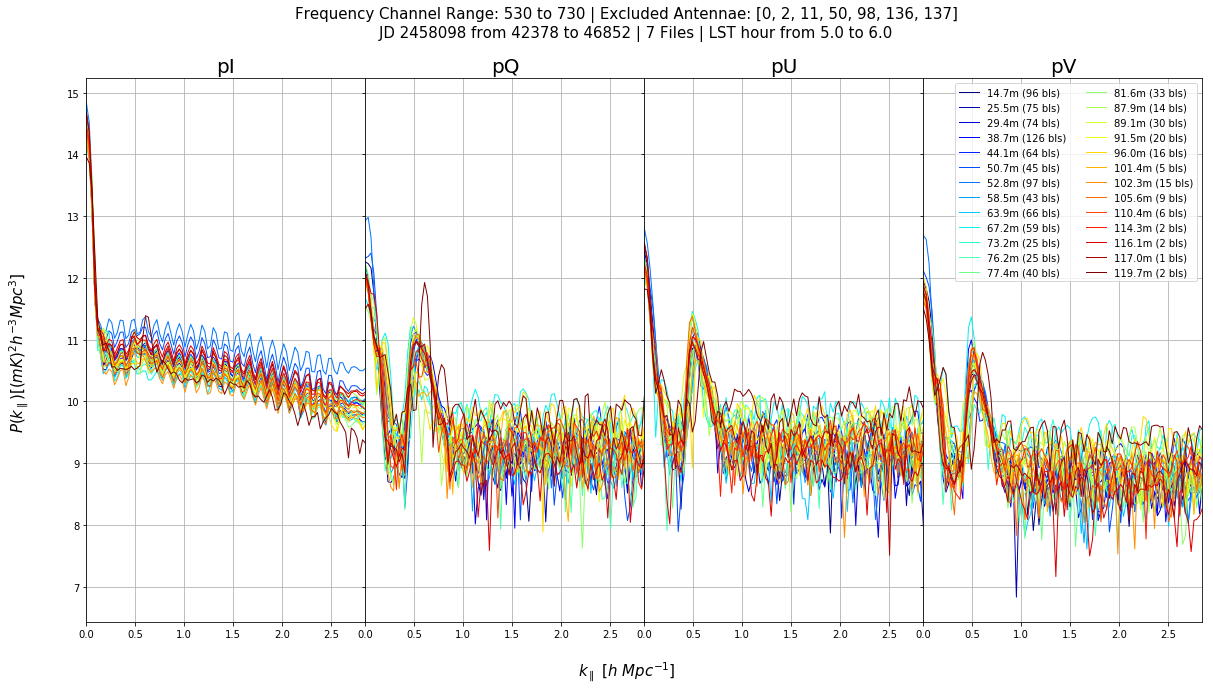

In [9]:
"""Making plots:"""
# Determine how many rows and columns are needed
if (len(dfiles) <= 4) or (len(dfiles) > 8):
    ncols = len(dfiles)
    nrows = 1
else:
    ncols = 4
    nrows = 2
# Initialize the axes objects
f, axes = plt.subplots(
    ncols=ncols,
    nrows=nrows,
    sharex=True,
    sharey=True,
    squeeze=False,
    figsize=(20, 10))

# Plot each file
pols = []
plt.subplots_adjust(wspace=0, hspace=0.1)
for dfile, ax in zip(dfiles, axes.flatten()):
    # Load in UVPspec objects and average the spectra along redundant baseline groups and time
    uvp = hp.UVPSpec()
    uvp.read_hdf5(dfile)
    uvp.average_spectra(blpair_groups=blp_reds.values(), time_avg=True)

    # Format data array
    data = uvp.data_array[0][:, :, 0]
    if wedge:
        uvp.fold_spectra()
        data = uvp.data_array[0][:, data.shape[1] // 2:, 0]
        
    def get_cmap(n, name='jet'):
        return plt.cm.get_cmap(name, n)
    cmap = get_cmap(data.shape[0])

    # Format x-axis values and set x-axis label
    x_axis = (uvp.get_dlys(0)*1e9).tolist()
    if cosmo:
        x_axis = uvp.get_kparas(0).tolist()
        
    # Add 0 at the start of the x-axis array
    if wedge:
        x_axis.insert(0, 0)
    ax.set_xlim((x_axis[0], x_axis[-1]))

    # Plot each redundant baseline power spectra
    for i, group in enumerate(data):
        ax.plot(
            x_axis,
            np.log10(np.abs(group)),
            c=cmap(i),
            label='{norm}m ({bls} bls)'.format(norm=norms[i], bls=len(bls_reds[norms[i]])),
            lw=1,
            ls='-')
    
    pol = pol_int_to_str[uvp.pol_array[0]]
    pols.append(pol)
    
    ax.grid()
    ax.set_title(pol, fontsize=20)
if cosmo:
    f.text(0.5, 0.05, r'$k_{\parallel}\ [h\ Mpc^{-1}]$', fontsize=15, ha='center')
    f.text(0.07, 0.5, r'$P(k_{\parallel}) [(mK)^2h^{-3}Mpc^3]$', fontsize=15, va='center', rotation='vertical')
else:
    f.text(0.5, 0.05, r'$\tau\ [ns]$', fontsize=15, ha='center')
    f.text(0.07, 0.5, r'$P(\tau) [(mK)^2]$', fontsize=15, va='center', rotation='vertical')
f.suptitle('Frequency Channel Range: {} to {} | Excluded Antennae: {}\n\
    JD {} from {} to {} | {} Files | LST hour from {} to {}'.format(
    FREQrng[0],
    FREQrng[1],
    str(xants),
    JD,
    JDt0,
    JDtf,
    numfiles,
    LSTrng[0],
    LSTrng[1]), fontsize=15)
plt.legend(loc='upper right', ncol=2)

pols = '_'.join(pols)
if wedge:
    tag_wedge = '1d_w'
else:
    tag_wedge = '1d_p'

if cosmo:
    tag_unit = 'cos'
else:
    tag_unit = 'std'
plt.savefig('zen.{JD}.{JDt0}_{JDtf}.{pols}.HH.{tagw}_{tagu}.{ext}.pdf'.format(
    JD=JD,
    JDt0=JDt0,
    JDtf=JDtf,
    pols=pols,
    tagw=tag_wedge,
    tagu=tag_unit,
    ext=ext))